In [ ]:
import numpy as np
import pyswarms as ps
from scipy import linalg 
from solver_for_Pocklington_equation import directional_pattern

# Константы
light_speed, mu0, eps0, incident_voltage, frequency = 299792458., 4*np.pi*1e-7, 8.854e-12, 10, 1e6 * 146
omega = 2 * np.pi * frequency

delta_z = light_speed / frequency / 1e2

k_form, k_max, k_side = 1, 1, 1
E_0 = 0.4 # характерное поле

phi = np.linspace(1e-6, 2*np.pi-1e-6, 1000)
aim_func = np.zeros(len(phi))
for i in range(len(phi)): aim_func[i] = max(0,np.sin(np.pi/2-phi[i]))**7 

def fit_form (E_total):
    return np.clip(1 - np.dot(E_total/np.max(E_total),aim_func)/np.linalg.norm(aim_func)/np.linalg.norm(E_total/np.max(E_total)),0, 1e9)

def fit_max (E_total):
    return np.clip(np.exp(1 - E_total[0]/E_0) - 1, 0, 1e9)

def fit_side (E_total):
    return np.clip(np.exp(np.max(E_total[int(len(phi)/4):int(len(phi)*3/4)])/E_total[0]) - 1, 0, 1e9)

# Определение функции для оптимизации
def my_objective_function(solution):
    fit = np.zeros(len(solution))
    num_elements = int(len(solution[0]) / 2)  # Убедитесь, что num_elements рассчитывается правильно
    
    for s in range(len(solution)):
        flag = False
        element_position = np.zeros((num_elements, 3)) 
        element_length = np.zeros(num_elements)           
        
        for i in range(num_elements):
            element_position[i] = [0, solution[s,i], 0] 
            element_length[i] = solution[s,num_elements + i]  
            if(element_length[i] <=0 or element_position[i][1] <= 0):
                flag = True   
        wire_radius = np.full(num_elements, 3.175e-3)
        source_position = np.array([element_position[0]], dtype=float) 
        
        
        for i in range(len(element_position)-1):
            for j in range(i+1,len(element_position)): 
                if(abs(element_position[i][1] - element_position[j][1]) <= 20*max(wire_radius[i],wire_radius[j])):
                    flag = True
        if flag == True :
            fit[s] = 1e9
        else :
            R, _, _, _, _, current, _, E_total, phi = directional_pattern (frequency, delta_z, incident_voltage, element_position, element_length, wire_radius, source_position)
            fit[s] = k_form * fit_form(E_total) + k_max * fit_max(E_total) + k_side * fit_side(E_total)
    return fit

# Настройка гиперпараметров
options = {
    'c1': 1.5,  # Коэффициент когнитивного притяжения
    'c2': 0.8,  # Коэффициент социального притяжения
    'w': 0.7  # Инерционный вес
}

num_elements = 8 # Убедитесь, что num_elements является положительным целым числом
dimensions = num_elements * 2 
wavelength = light_speed / frequency
# Нижние и верхние границы переменных
lb, ub = [], []
min_length, max_length = 0.4*wavelength, 0.52*wavelength
min_pos, max_pos = 0, wavelength*3/2
for i in range(dimensions):
    if(i<dimensions/2):
        lb.append(min_pos)
        ub.append(max_pos)
    else:
        lb.append(min_length)
        ub.append(max_length)
lb, ub = np.array(lb), np.array(ub)
bounds = (lb, ub)
# Создание оптимизатора PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=dimensions, options=options, bounds=bounds)

# Выполнение оптимизации
best_cost, best_pos = optimizer.optimize(my_objective_function, iters=100)

# Вывод результатов
print("Лучшее значение:", best_cost)
print("Лучшая позиция:", best_pos)


In [ ]:
from pyswarms.utils.plotters import plot_cost_history
import matplotlib.pyplot as plt
# После выполнения оптимизации
cost_history = np.array(optimizer.cost_history)
positions_history = np.array(optimizer.pos_history)
plt.show()
plt.plot(np.arange(len(cost_history)), cost_history-0.5, color = 'black')
plt.title("Best fit, 10 particles", size = 14)
plt.ylabel("Best cost in generation", size = 12)
plt.xlabel("Iteration", size = 12)

In [ ]:
cost1 = cost_history


In [ ]:
solution = best_pos
delta_z = light_speed / frequency / 4e2
element_position = np.zeros((num_elements, 3)) 
element_length = np.zeros(num_elements)           
for i in range(num_elements):
    element_position[i] = [0, solution[i], 0] 
    element_length[i] = solution[num_elements + i]     
wire_radius = np.full(num_elements, 3.175e-3)
source_position = np.array([element_position[0]], dtype=float) 
R, R_block, element_num, incident_field, impedance, current, current_block, E_total, phi = directional_pattern (frequency, delta_z, incident_voltage, element_position, element_length, wire_radius, source_position)

In [ ]:
import matplotlib.pyplot as plt
# Создание полярной фигуры
fig = plt.figure(figsize=(12, 6))
solution_fitness = best_cost
# Подграфик 1: Нормированный график
ax1 = fig.add_subplot(121, polar=True)
ax1.plot(phi, E_total / np.max(E_total), label='Solution')
ax1.plot(phi,aim_func, label='Aim function')
ax1.set_title("Normalized DP")
ax1.legend()

# Подграфик 2: Оригинальный график
ax2 = fig.add_subplot(122, polar=True)
ax2.plot(phi, E_total, label='Solution')
ax2.plot(phi, aim_func*E_0, label='Aim function')
ax2.set_title(f"Directional pattern (fit:{np.round(solution_fitness,3)})")
ax2.legend()

# Отображение графиков
plt.tight_layout()
plt.show()
print(k_form * fit_form(E_total) , k_max * fit_max(E_total) , k_side * fit_side(E_total))

NameError: name 'solution_fitness' is not defined

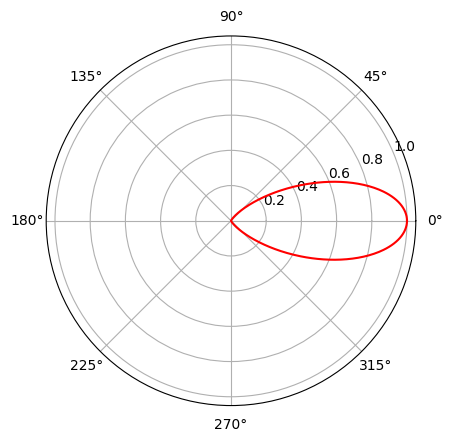

In [7]:
import numpy as np
import matplotlib.pyplot as plt
phi = np.linspace(1e-6, 2*np.pi-1e-6, 1000)
aim_func = np.zeros(len(phi))
for i in range(len(phi)): aim_func[i] = max(0,np.sin(np.pi/2-phi[i]))**7 
plt.polar(phi, aim_func, label='Aim function', color = 'red')
plt.title(f"Directional pattern (fit:{np.round(solution_fitness,3)})")
plt.legend()

In [ ]:
from visualization import plot_2dmodel, plot_together, plot_separately, current_distribution_2d, current_distribution_3d

plot_2dmodel(R, source_position, sum(element_num), delta_z)
plot_together(R_block, current_block)
#plot_separately(R_block, current_block)
current_distribution_2d(R, current)
#current_distribution_3d(R, source_position, R_block, current_block)